In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:

# Load SIFT detector
sift = cv2.SIFT_create()

In [3]:
products_description = {
    '0.jpg': 'Nesquik no scritte',
    '1.jpg': 'ChocoKrave blu',
    '2.jpg': 'CornFlakes',
    '3.jpg': 'ChokoGoal',
    '4.jpg': 'SlimChocolate',
    '5.jpg': 'Nesquik cereali',
    '6.jpg': 'Nesquik duo',
    '7.jpg': 'CocoPops risociok',
    '8.jpg': 'CocoPops palline rosso',
    '9.jpg': 'SpecialK classic',
    '10.jpg': 'SpecialK fondente',
    '11.jpg': 'ChocoKrave',
    '12.jpg': 'Fitness fruits',
    '13.jpg': 'Fitness azzurro',
    '14.jpg': 'Chocapic',
    '15.jpg': 'CocoPops rotelle',
    '16.jpg': 'MielPops nocciola',
    '17.jpg': 'MielPops anellini',
    '18.jpg': 'CountryCrisp',
    '19.jpg': 'CountryCrisp nuts azzurro',
    '20.jpg': 'SpecialK frutti rossi',
    '21.jpg': 'RiceKrispies',
    '22.jpg': 'Cheerios',
    '23.jpg': 'SpecialK classic',
    '24.jpg': 'Fitness pink edition',
    '25.jpg': 'CocoPops palline rosso con regalo',
    '26.jpg': 'Nesquik duo con regalo fucsia',
}

In [4]:
def match(model, scene, threshold=0.75, k=2):
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    # Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(model, scene, k)
    #defining an array containing all the matches that results to be considered "good" matches applying a certain treshold 
    good_matches = []
    for m,n in matches:
        if m.distance < threshold * n.distance: #  if m.distance/n.distance < Threshold:
            good_matches.append(m)
            
    return good_matches

def nms(boxes, scores, overlapThresh):
    # If there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # Initialize the list of picked indexes
    pick = []

    # Grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # Compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)

    # Keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # Grab the last index in the indexes list and add the index
        # value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the largest (x, y) coordinates for the start of the bounding box
        # and the smallest (x, y) coordinates for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # Delete all indexes from the index list that have a large overlap
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # Return only the bounding boxes that were picked
    return boxes[pick], pick


In [34]:
def image_to_color_bins_lab(image_path, grid_size=(4, 4), roi=None):
    # Read the image and convert it to the LAB color space
    image = cv2.imread(image_path)
    
        # If a region of interest is provided, crop the image to that region
    if roi is not None:
        x, y, w, h = roi
        image = image[y:y+h, x:x+w]
        # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # plt.show()
        
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    image_height, image_width, _ = lab_image.shape

    # Calculate the size of each bin
    bin_height = image_height // grid_size[0]
    bin_width = image_width // grid_size[1]
    # List to hold the average color per bin
    average_colors = []

    # Loop over the grid
    for i in range(0, image_height, bin_height):
        if i + bin_height > image_height:
            continue
        for j in range(0, image_width, bin_width):
            if j + bin_width > image_width:
                continue
            # Compute the boundaries of the bin
            bin_roi = lab_image[i:i+bin_height, j:j+bin_width]

            # Compute the average color of the bin
            average_color = cv2.mean(bin_roi)[:3]  # Slice to exclude the alpha channel if present
            average_colors.append(average_color)
    # return np.array(average_colors)
    v = np.array(average_colors)
    return cv2.normalize(v, v).flatten()

def cosine_distance(a, b):
    # Compute the cosine similarity
    cosine_similarity = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    # Compute the cosine distance
    distance = 1 - cosine_similarity
    return distance

def compute_iou(rect_a, rect_b):
    # Unpack the coordinates
    min_x_a, max_x_a, min_y_a, max_y_a = rect_a
    min_x_b, max_x_b, min_y_b, max_y_b = rect_b

    # Calculate the intersection coordinates
    intersection_min_x = max(min_x_a, min_x_b)
    intersection_max_x = min(max_x_a, max_x_b)
    intersection_min_y = max(min_y_a, min_y_b)
    intersection_max_y = min(max_y_a, max_y_b)

    # Calculate the area of intersection
    intersection_area = max(0, intersection_max_x - intersection_min_x) * max(0, intersection_max_y - intersection_min_y)

    # Calculate the area of both rectangles
    area_a = (max_x_a - min_x_a) * (max_y_a - min_y_a)
    area_b = (max_x_b - min_x_b) * (max_y_b - min_y_b)

    # Calculate the area of the union
    union_area = area_a + area_b - intersection_area

    # Calculate the IoU
    iou = intersection_area / union_area if union_area != 0 else 0
    
    return iou

In [35]:
def calc_histogram(image_path, bins_per_channel=32, roi=None):
    # Read the image
    image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    
    # If a region of interest is provided, crop the image to that region
    if roi is not None:
        x, y, w, h = roi
        image = image[y:y+h, x:x+w]
        # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # plt.show()

    # Calculate the histogram for each color channel using the specified number of bins
    histogram = cv2.calcHist([image], [0, 1, 2], None, [bins_per_channel]*3, [0, 256, 0, 256, 0, 256])
    # Normalize and flatten the histogram for comparison
    return cv2.normalize(histogram, histogram).flatten(), image

# Function to compare two histograms
def compare_histograms(hist1, hist2, method=cv2.HISTCMP_CORREL):
    score = cv2.compareHist(hist1, hist2, method)
    return score

SCENE e1.png
	Product 26.jpg (Nesquik duo con regalo fucsia), found IoU of 89.9% with product 0.jpg. Keeping 0.jpg since it has 292 VS 52 matches of product 26.jpg
	Product 0.jpg (Nesquik no scritte) - Instance found:
		Instance 1 {position: (163.00, 219.00), width: 312.00px, height: 438.00px}, good matches are 292.
	Product 11.jpg (ChocoKrave) - Instance found:
		Instance 1 {position: (443.00, 182.50), width: 302.00px, height: 365.00px}, good matches are 81.


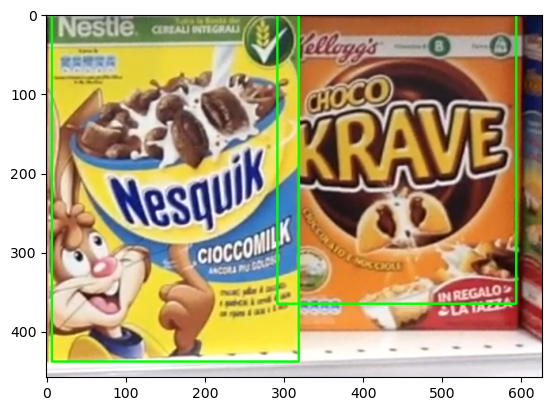

SCENE e2.png
	Product 26.jpg (Nesquik duo con regalo fucsia), found IoU of 58.5% with product 0.jpg. Keeping 26.jpg since it has 190 VS 97 matches of product 0.jpg
	Product 24.jpg (Fitness pink edition) - Instance found:
		Instance 1 {position: (168.50, 232.50), width: 337.00px, height: 465.00px}, good matches are 206.
	Product 26.jpg (Nesquik duo con regalo fucsia) - Instance found:
		Instance 1 {position: (539.50, 231.50), width: 337.00px, height: 463.00px}, good matches are 190.
	Product 25.jpg (CocoPops palline rosso con regalo) - Instance found:
		Instance 1 {position: (876.00, 231.50), width: 324.00px, height: 449.00px}, good matches are 201.


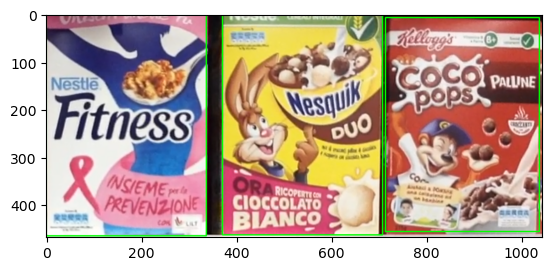

SCENE e3.png
	Product 0.jpg (Nesquik no scritte) - Instance found:
		Instance 1 {position: (170.00, 232.50), width: 328.00px, height: 441.00px}, good matches are 261.
	Product 1.jpg (ChocoKrave blu) - Instance found:
		Instance 1 {position: (817.00, 201.00), width: 310.00px, height: 402.00px}, good matches are 131.
	Product 11.jpg (ChocoKrave) - Instance found:
		Instance 1 {position: (474.50, 192.50), width: 307.00px, height: 341.00px}, good matches are 57.


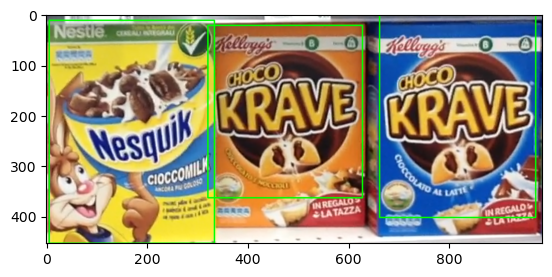

SCENE e4.png
	Product 0.jpg (Nesquik no scritte) - Instance found:
		Instance 1 {position: (161.00, 735.50), width: 322.00px, height: 441.00px}, good matches are 215.
	Product 11.jpg (ChocoKrave) - Instance found:
		Instance 1 {position: (463.00, 691.00), width: 306.00px, height: 396.00px}, good matches are 82.
	Product 26.jpg (Nesquik duo con regalo fucsia) - Instance found:
		Instance 1 {position: (204.50, 222.00), width: 345.00px, height: 444.00px}, good matches are 173.
	Product 25.jpg (CocoPops palline rosso con regalo) - Instance found:
		Instance 1 {position: (519.50, 288.50), width: 389.00px, height: 577.00px}, good matches are 157.


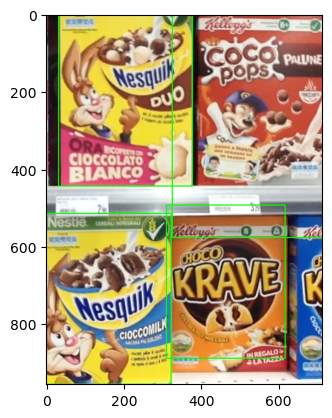

SCENE e5.png
	Product 19.jpg (CountryCrisp nuts azzurro) - Instance found:
		Instance 1 {position: (503.00, 191.00), width: 300.00px, height: 382.00px}, good matches are 152.
	Product 25.jpg (CocoPops palline rosso con regalo) - Instance found:
		Instance 1 {position: (162.00, 227.50), width: 324.00px, height: 451.00px}, good matches are 173.


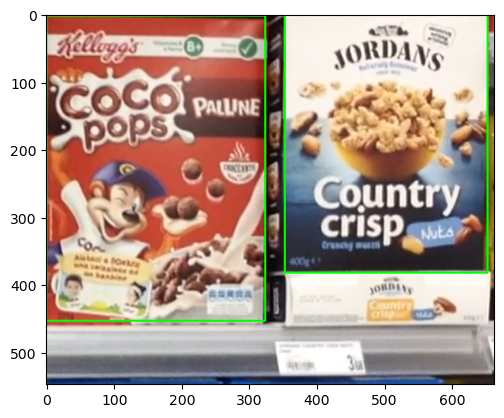

In [42]:

# Load product images and extract features
product_images = ['0.jpg', '1.jpg', '11.jpg', '19.jpg', '24.jpg', '26.jpg', '25.jpg']
# product_images = ['0.jpg', '11.jpg']
product_features = {}

bins = 128
# for img_name in product_images:
#     img = cv2.imread('images/models/' + img_name, cv2.IMREAD_GRAYSCALE)
#     kp, des = sift.detectAndCompute(img, None)
#     product_features[img_name] = (kp, des)

# For each scene image
scene_images = ['e1.png', 'e2.png', 'e3.png', 'e4.png', 'e5.png']
for scene_img_name in scene_images[:]:
    scene_img = cv2.imread('images/scenes/' + scene_img_name, cv2.IMREAD_GRAYSCALE)
    scene_img_color = cv2.imread('images/scenes/' + scene_img_name)

    results = dict()
    print(f'SCENE {scene_img_name}\n')
    # for img_name, (kp, des) in product_features.items():
    boxes = []
    scores = []
    for img_name in product_images:
        img = cv2.imread('images/models/' + img_name, cv2.IMREAD_GRAYSCALE)
        kp, des = sift.detectAndCompute(img, None)
        product_features[img_name] = (kp, des)
        found = False
        
        detection_mask = np.ones(scene_img.shape[:2], dtype=np.uint8)

        while not found:
            scene_kp, scene_des = sift.detectAndCompute(scene_img, detection_mask)

            good_matches = match(des, scene_des, threshold=0.6)
            # print(f"\tProduct {img_name} - good matches are {len(good_matches)}. Dynamic threshold is {(dynamic_threshold)}")

            # If sufficient matches found, calculate homography and bounding box
            if len(good_matches) >= 50:
                src_pts = np.float32([kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([scene_kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                
                # Transform the corners of the product image to get the bounding box in the scene image
                h, w = img.shape
                pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
                scene_pts = cv2.perspectiveTransform(pts, M)
                # Flatten the list of points
                scene_pts = scene_pts.reshape(-1, 2)
                
                scene_img = cv2.polylines(scene_img, [np.int32(scene_pts)], True, (0, 255, 0), 3, cv2.LINE_AA)
                # Get the bounding box parameters
                min_x, min_y = np.min(scene_pts, axis=0)
                max_x, max_y = np.max(scene_pts, axis=0)
                
                min_x = int(max(min_x, 0))
                min_y = int(max(min_y, 0))
                max_x = int(min(max_x, scene_img.shape[1]))
                max_y = int(min(max_y, scene_img.shape[0]))
                
                # Calculate the center, width, and height
                width = max_x - min_x
                height = max_y - min_y
                
                if width > height:
                    break
                    
                product_hist, product_img = calc_histogram('images/models/' + img_name, bins_per_channel=bins)
                patch_hist, patch_img = calc_histogram('images/scenes/' + scene_img_name, roi=(min_x, min_y, width, height), bins_per_channel=bins)
                color_score = compare_histograms(product_hist, patch_hist, cv2.HISTCMP_INTERSECT)
    
                # Now, you can calculate the color bins for two images in the LAB color space
                grid_size = (8, 8)  # Example grid size
                product_colors = image_to_color_bins_lab('images/models/' + img_name, grid_size=grid_size)
                patch_colors = image_to_color_bins_lab('images/scenes/' + scene_img_name, roi=(min_x, min_y, width, height), grid_size=grid_size)
                # Continue with comparison as before...
                color_distance = cosine_distance(product_colors, patch_colors)
                
                if color_distance >= 0.020:
                    detection_mask[min_y:max_y, min_x:max_x] = 0
                    scene_kp, scene_des = sift.detectAndCompute(scene_img, detection_mask)
                    # plt.imshow(detection_mask)
                    # plt.show()
                    # print(f'\tProduct {img_name} ({products_description[img_name]}) - color distance is too high! {color_distance:.3f}')
                    continue
                else:
                    found = True
                    
                to_remove = False
                for result in results.copy():
                    iou = compute_iou(result, (min_x, max_x, min_y, max_y))
                    if iou >= 0.5:
                        if results[result]['matches'] > len(good_matches):
                            print(f'\tProduct {img_name} ({products_description[img_name]}), found IoU of {100 * iou:.1f}% with product {results[result]["product"]}. Keeping {results[result]["product"]} since it has {results[result]["matches"]} VS {len(good_matches)} matches of product {img_name}')
                            to_remove = True
                        else:
                            print(f'\tProduct {img_name} ({products_description[img_name]}), found IoU of {100 * iou:.1f}% with product {results[result]["product"]}. Keeping {img_name} since it has {len(good_matches)} VS {results[result]["matches"]} matches of product {results[result]["product"]}')
                            results.pop(result)
                        
                if not to_remove:  
                    results[(min_x, max_x, min_y, max_y)] = {'matches': len(good_matches), 'product': img_name}
                # print(results)
                # found = True
                # _, axs = plt.subplots(1, 2, figsize=(5, 10))
                # axs = axs.flatten()
                # for img, ax in zip([cv2.cvtColor(product_img, cv2.COLOR_BGR2RGB), cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB)], axs):
                #     ax.imshow(img)
                # plt.show()
                # if color_score <= 1:
                #     continue
                
            else:
                found = True
                
    for result in results:
        min_x, max_x, min_y, max_y = result
        width = max_x - min_x
        height = max_y - min_y
        matches = results[result]['matches']
        product = results[result]['product']
        
        center_x = min_x + (width / 2)
        center_y = min_y + (height / 2)
        
        # Draw the bounding box
        # scene_img_color = cv2.polylines(scene_img_color, [np.int32(scene_pts)], True, (0, 255, 0), 3, cv2.LINE_AA)
        scene_img_color = cv2.rectangle(scene_img_color, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)

        # Print the output
        print(f"\tProduct {product} ({products_description[product]}) - Instance found:")
        print(f"\t\tInstance 1 {{position: ({center_x:.2f}, {center_y:.2f}), width: {width:.2f}px, height: {height:.2f}px}}, good matches are {matches}.")
    plt.imshow(cv2.cvtColor(scene_img_color, cv2.COLOR_BGR2RGB))
    plt.show()
        # Display the scene image with all bounding boxes
    # cv2.imshow(f'Scene with Bounding Boxes - {scene_img_name}', scene_img_color)
    # cv2.waitKey(0)  # Wait for a key press to proceed
    # cv2.destroyAllWindows()  # Close the window after key press